In [1]:
%load_ext autoreload
%autoreload 2

import datetime
import numpy as np
import scipy as sp
import pandas as pd
import functools as fts
import multiprocessing as mp
from tqdm.notebook import tqdm
from tqdm.contrib import tzip, tenumerate, tmap

from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.storagelevel import StorageLevel
from pyspark.sql.functions import col
import pyspark.sql.types as pstype
import pyspark.sql.functions as F
import pyspark as ps

import matplotlib as mlt
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML
import japanize_matplotlib

from time_series_model import *

%matplotlib inline
%matplotlib ipympl

In [2]:
SPECIFIED_PATH = "csv_data/"
SPECIFIED_DATE = "20240918"
SPECIFIED_CSV  = SPECIFIED_PATH + SPECIFIED_DATE

In [9]:
lags       = 5
data_num   = 1000
δ1         = 2
δ2         = 1
Σ          = 4 ** 2
regression = "ct"
if   regression == "n":
    x_data    = np.zeros(data_num)
    x_data[0] = 0
    for idx in range(1, data_num):
        st, en = max(0, idx-lags), idx
        s = x_data[st:en].mean()
        ε = np.random.normal(0, Σ)
        
        x_data[idx] = s + ε

elif regression == "c":
    x_data    = np.zeros(data_num)
    x_data[0] = np.random.normal(0, Σ) * 100
    for idx in range(1, data_num):
        st, en = max(0, idx-lags), idx
        s = x_data[st:en].mean()
        ε = np.random.normal(0, Σ)
        
        x_data[idx] = s + ε

elif regression == "ct":
    x_data    = np.zeros(data_num)
    x_data[0] = np.random.normal(0, Σ) * 100
    for idx in range(1, data_num):
        st, en = max(0, idx-lags), idx
        s = x_data[st:en].mean()
        ε = np.random.normal(0, Σ)
        
        x_data[idx] = s + ε + δ1

elif regression == "ctt":
    x_data    = np.zeros(data_num)
    x_data[0] = np.random.normal(0, Σ) * 100
    for idx in range(1, data_num):
        st, en = max(0, idx-lags), idx
        s = x_data[st:en].mean()
        ε = np.random.normal(0, Σ)
        
        x_data[idx] = s + ε + δ1 + δ2 * idx
else:
    raise

pd_data = pd.DataFrame({"x_data": x_data})
pd_data.to_csv(SPECIFIED_CSV + "_urp_data.csv", header=True, index=False)
pd_data

,x_data
0,614.022691
1,632.367493
2,624.097352
3,641.741981
4,607.619822
...,...
995,1416.845301
996,1405.392294
997,1476.165672
998,1383.937761


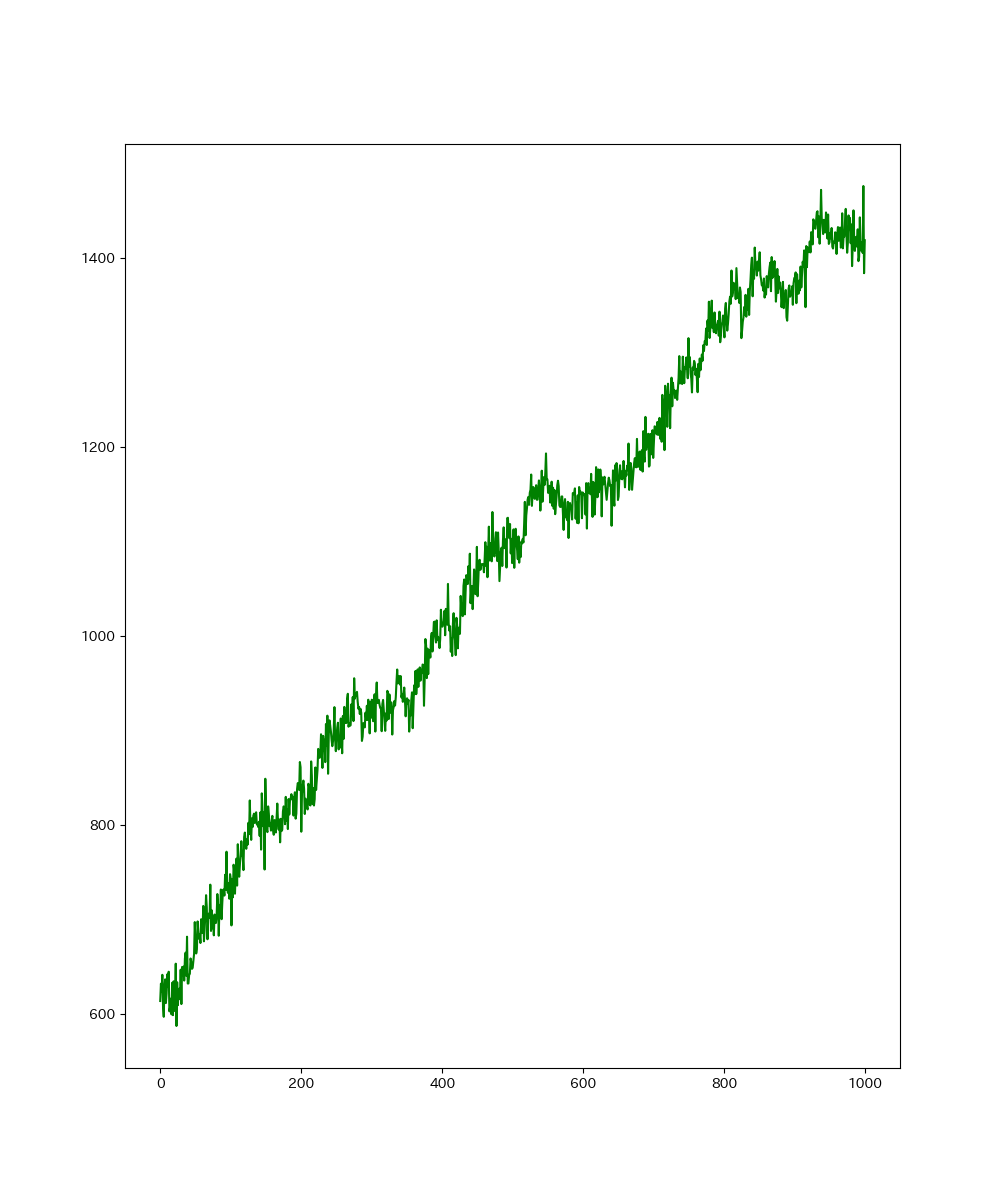

In [10]:
plt.figure(figsize=(10, 12))
plt.plot(x_data, "-", color="green")

In [11]:
from statsmodels.tsa.stattools import adfuller

# regression：データ構造により以下から指定
# n  ・・・定数項なし&トレンドなし
# c  ・・・定数項あり&トレンドなし
# ct ・・・定数項あり&1次のトレンドあり
# ctt・・・定数項あり&1次のトレンドあり&2次のトレンドあり
result = adfuller(pd_data.to_numpy(), autolag="BIC", regression="ct")

print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
print("used lag: %d" % result[2])
print("data num: %d" % result[3])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
print("ic best: %f" % result[5])

ADF Statistic: -2.867174
p-value: 0.173366
used lag: 4
data num: 995
	1%: -3.968
	5%: -3.415
	10%: -3.130
ic best: 8216.557871
